In [1]:
# prepare_data_for_eda.py scrip, without saving out to pkl or csv
import os
import pandas as pd
import logging.config
import matplotlib.pyplot as plt

import numpy as np
from cycler import cycler #for matplotlib colors
import seaborn as sns
from sklearn import preprocessing

import plot_functions as pf
import importlib
import missingno as msno


LOGGING_CONFIG = os.getenv('LOGGING_CONFIG')
logging.config.fileConfig(LOGGING_CONFIG)
logger = logging.getLogger('prepare_data_for_eda')

In [2]:
DATADIR = os.getenv('DATADIR')
logger.info("using DATADIR {}".format(DATADIR))

2018-06-06 12:46:11,249 - prepare_data_for_eda - INFO - using DATADIR ../DATA


In [3]:
content_performance = pd.read_csv(os.path.join(DATADIR, 'content_performance.csv.gz'),  compression='gzip', 
                                 dtype={'pageviews': 'float64',
 'unique_pageviews': 'float64',
 'feedex_comments': 'float64',
 'is_this_useful_yes': 'float64',
 'is_this_useful_no': 'float64',
 'number_of_internal_searches': 'float64',
 'exits': 'float64',
 'entrances': 'float64',
 'bounce_rate': 'float64',
 'avg_time_on_page': 'float64',
 'id': 'int64',
 'content_id': 'object',
 'title': 'object',
 'base_path': 'object',
 'description': 'object',
 'number_of_pdfs': 'float64',
 'document_type': 'object',
 'content_purpose_document_supertype': 'object',
 'first_published_at': 'object',
 'public_updated_at': 'object',
 'number_of_word_files': 'float64',
 'status': 'object',
 'readability_score': 'float64',
 'contractions_count': 'float64',
 'equality_count': 'float64',
 'indefinite_article_count': 'float64',
 'passive_count': 'float64',
 'profanities_count': 'float64',
 'redundant_acronyms_count': 'float64',
 'repeated_words_count': 'float64',
 'simplify_count': 'float64',
 'spell_count': 'float64',
 'string_length': 'float64',
 'sentence_count': 'float64',
 'word_count': 'float64',
 'primary_organisation_title': 'object',
 'primary_organisation_content_id': 'object',
 'primary_organisation_withdrawn': 'object',
 'content_hash': 'object',
 'locale': 'object',
 'publishing_api_payload_version': 'int64',
 '_merge': 'category',
 'count_survey_responses': 'float64',
 'response_per_pageview': 'float64',
 'response_per_unique_pageview': 'float64',
 'useful_per_responses': 'float64',
 'total_to_unique_pageviews': 'float64',
 'create_total_to_unique_pageviews': 'float64',
 'feedex_per_unique_1000': 'float64',
 'searches_per_pageview_1000': 'float64',
 'contractions_count_scaled': 'float64',
 'indefinite_article_count_scaled': 'float64',
 'redundant_acronyms_count_scaled': 'float64',
 'repeated_words_count_scaled': 'float64',
 'spell_count_scaled': 'float64',
 'readability_score_scaled': 'float64',
 'equality_count_scaled': 'float64',
 'passive_count_scaled': 'float64',
 'simplify_count_scaled': 'float64',
 'profanities_count_scaled': 'float64',
 'spelling_grammar': 'float64',
 'style': 'float64',
 'errors': 'float64'})

In [4]:
conditions = [
    (content_performance.base_path.str.startswith('/government', na=False)), 
    (content_performance.base_path.str.startswith('/guidance', na=False))]
     
choices = ['whitehall',  'guides_manuals']
content_performance['content_management'] = np.select(conditions, choices, default='mostly_mainstream')

#### Useful_per_response

In [5]:
content_performance.useful_per_responses.describe()

count    33579.000000
mean         0.717001
std          0.386921
min          0.000000
25%          0.500000
50%          1.000000
75%          1.000000
max          1.000000
Name: useful_per_responses, dtype: float64

Text(0.5,1,'Percent of respondents who found edition useful')

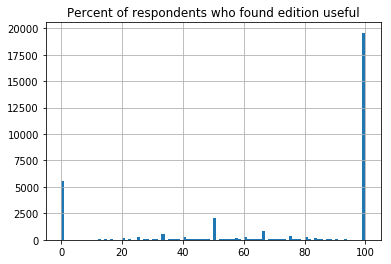

In [6]:
(content_performance['useful_per_responses']*100).hist(bins=100, range=(0, 100))
plt.title('Percent of respondents who found edition useful')

In [7]:
content_performance[content_performance['count_survey_responses']>1000].shape

(65, 65)

In [8]:
def estimate_sample_size(p_hat, z, accuracy):
    n = (p_hat*(1-p_hat)*z**2)/accuracy**2
    print ("Estimating the required sample size to estimate a proportion within {}% \n given our uninformative estimate of {}%, making this a conservative n".format(accuracy*100, p_hat*100, ))
    return n

In [9]:
estimate_sample_size(0.5, 1.96, 0.1)

Estimating the required sample size to estimate a proportion within 10.0% 
 given our uninformative estimate of 50.0%, making this a conservative n


96.03999999999998

In [10]:
accurate_proportions = content_performance[content_performance['count_survey_responses']>100]

In [11]:
accurate_proportions.shape

(575, 65)

In [12]:
accurate_proportions.shape[0]/content_performance.id.nunique()*100

0.12867852747006825

In [13]:
content_performance.id.nunique()

446850

In [14]:
accurate_proportions.id.nunique()

575

In [15]:
accurate_proportions.shape[0]/sum(content_performance['count_survey_responses']>0)*100

1.7123797611602491

In [16]:
sum(content_performance['count_survey_responses']>0)

33579

Text(0.5,1,'Percent of respondents who found edition useful')

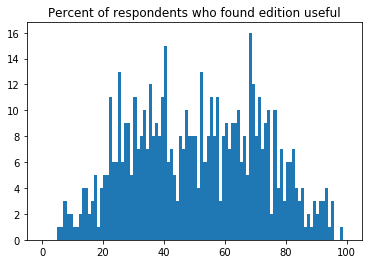

In [17]:
(accurate_proportions['useful_per_responses']*100).hist(bins=100, range=(0, 100), grid=False)
plt.title('Percent of respondents who found edition useful')

In [18]:
#accurate_proportions.to_csv(os.path.join(DATADIR, 'accurate_proportions.csv.gz'), compression='gzip')
accurate_proportions.to_csv('../DATA/accurate_proportions.csv')

#### responses_per_pageview

In [19]:
content_performance = content_performance.replace([np.inf, -np.inf], np.nan).copy()

In [20]:
content_performance.response_per_pageview.describe()

count    299340.000000
mean          0.006789
std           0.056594
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.600000
Name: response_per_pageview, dtype: float64

In [21]:
content_performance[content_performance['response_per_unique_pageview']>1]

,Unnamed: 0,pageviews,unique_pageviews,feedex_comments,is_this_useful_yes,is_this_useful_no,number_of_internal_searches,exits,entrances,bounce_rate,...,spell_count_scaled,readability_score_scaled,equality_count_scaled,passive_count_scaled,simplify_count_scaled,profanities_count_scaled,spelling_grammar,style,errors,content_management
142909,258314,3.0,2.0,0.0,4.0,0.0,0.0,1.0,2.0,0.000000,...,0.000101,0.011412,0.0,0.004762,0.003964,0.000000,0.000101,0.020138,0.000101,whitehall
248323,384576,5.0,5.0,0.0,4.0,4.0,0.0,3.0,4.0,6.976744,...,0.001106,0.011582,0.0,0.004762,0.002973,0.002454,0.001106,0.019317,0.003560,whitehall


Can't yet explain why these items were only viewed once but have 5 survey responses. 
Concerning regarding the denominator!

Text(0,0.5,'responses')

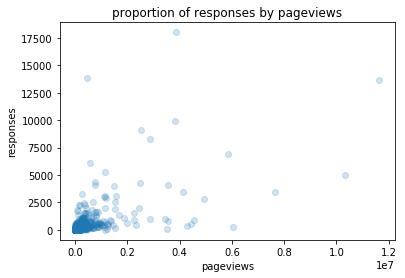

In [22]:
plt.scatter(content_performance.pageviews,  content_performance.count_survey_responses, alpha=0.2)
plt.title("proportion of responses by pageviews")
plt.xlabel('pageviews')
plt.ylabel('responses')

In [23]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(content_performance.pageviews, content_performance.count_survey_responses)

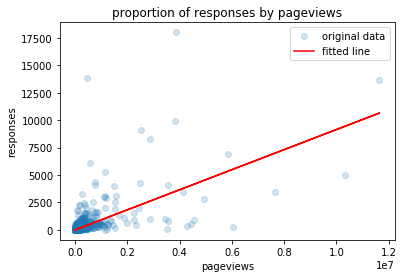

In [24]:
plt.plot(content_performance.pageviews, content_performance.count_survey_responses, 'o', label='original data', alpha=0.2)
plt.title("proportion of responses by pageviews")
plt.xlabel('pageviews')
plt.ylabel('responses')
plt.plot(content_performance.pageviews, intercept + slope*content_performance.pageviews, 'r', label='fitted line')
plt.legend()
plt.show()

Text(0,0.5,'response rate (per pageview)')

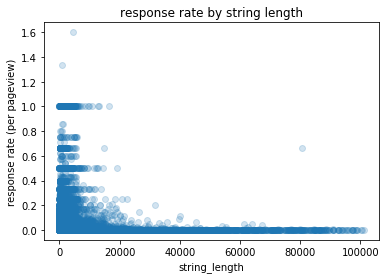

In [25]:
plt.plot(content_performance.string_length, content_performance.response_per_pageview, 'o', label='original data', alpha=0.2)
plt.title("response rate by string length")
plt.xlabel('string_length')
plt.ylabel('response rate (per pageview)')

In [26]:
import statsmodels.api as sm
glm_poisson = sm.GLM(content_performance.count_survey_responses,content_performance.pageviews, family=sm.families.Poisson())
res = glm_poisson.fit()
print(res.summary())

/Users/ellieking/Documents/give-depts-data/give_data/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                   Generalized Linear Model Regression Results                    
Dep. Variable:     count_survey_responses   No. Observations:               446850
Model:                                GLM   Df Residuals:                   446849
Model Family:                     Poisson   Df Model:                            0
Link Function:                        log   Scale:                             1.0
Method:                              IRLS   Log-Likelihood:            -2.3842e+06
Date:                    Wed, 06 Jun 2018   Deviance:                   4.6778e+06
Time:                            12:46:31   Pearson chi2:                 3.38e+08
No. Iterations:                        13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pageviews   9.155e-07   3.73e-10   2454.091      0.000    9.15e-07    9.16e-07


In [27]:
# nobs = res.nobs
# # y = data.endog[:,0]/data.endog.sum(1)
# yhat = res.mu

In [28]:
# from statsmodels.graphics.api import abline_plot

In [29]:
# fig, ax = plt.subplots()
# ax.scatter(yhat, content_performance.count_survey_responses)
# line_fit = sm.OLS(content_performance.count_survey_responses, sm.add_constant(yhat, prepend=True)).fit()
# abline_plot(model_results=line_fit, ax=ax)


# ax.set_title('Model Fit Plot')
# ax.set_ylabel('Observed values')
# ax.set_xlabel('Fitted values')

Text(0,0.5,'p(responses)')

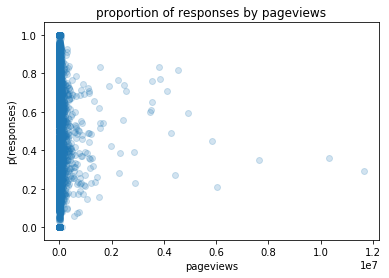

In [30]:
plt.scatter(content_performance.pageviews,  content_performance.useful_per_responses, alpha=0.2)
plt.title("proportion of responses by pageviews")
plt.xlabel('pageviews')
plt.ylabel('p(responses)')

/Users/ellieking/Documents/give-depts-data/give_data/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0,0.5,'p(responses)')

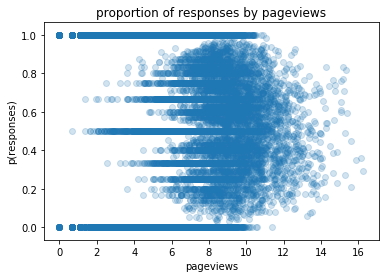

In [31]:
plt.scatter(np.log(content_performance.pageviews),  content_performance.useful_per_responses, alpha=0.2)
plt.title("proportion of responses by pageviews")
plt.xlabel('pageviews')
plt.ylabel('p(responses)')

Text(0.5,1,'proportion of repsondents who found page useful by responses')

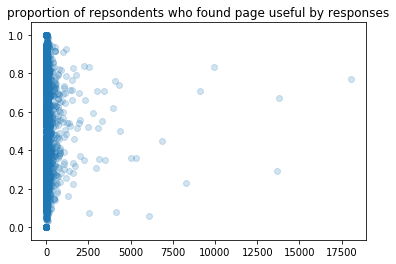

In [32]:
plt.scatter(content_performance.count_survey_responses,  content_performance.useful_per_responses, alpha=0.2)
plt.title("proportion of repsondents who found page useful by responses")

/Users/ellieking/Documents/give-depts-data/give_data/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5,1,'proportion of repsondents who found page useful by responses')

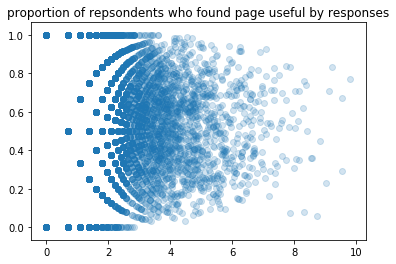

In [33]:
plt.scatter(np.log(content_performance.count_survey_responses),  content_performance.useful_per_responses, alpha=0.2)
plt.title("proportion of repsondents who found page useful by responses")

Really weird pattern in the low number of responses page

/Users/ellieking/Documents/give-depts-data/give_data/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5,1,'proportion of repsondents who found page useful by pageviews')

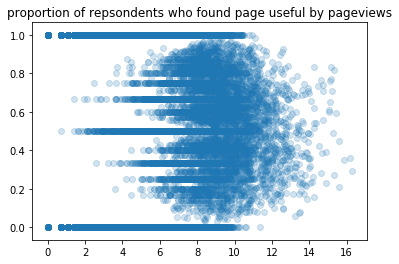

In [34]:
plt.scatter(np.log(content_performance.pageviews),  content_performance.useful_per_responses, alpha=0.2)
plt.title("proportion of repsondents who found page useful by pageviews")

In [35]:
np.log(2500)

7.824046010856292

In [36]:
np.log(100)

4.605170185988092

Text(0.5,1,'proportion of repsondents who found page useful by responses')

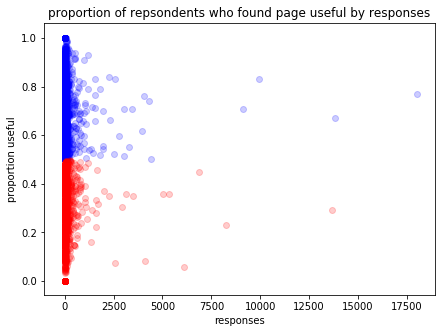

In [37]:
# normal values
plt.figure(figsize=(7, 5))
# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('responses')
plt.ylabel('proportion useful')
plt.scatter(content_performance.count_survey_responses[content_performance['useful_per_responses']>=0.5],  
                                                       content_performance.useful_per_responses[content_performance['useful_per_responses']>=0.5], 
                                                                                                c = 'b',
                                                                                                alpha=0.2, 
                                                                                                )
# less than 0.8
plt.scatter(content_performance.count_survey_responses[content_performance['useful_per_responses']<0.5 ],  
                                                       content_performance.useful_per_responses[content_performance['useful_per_responses']<0.5], 
                                                                                                c = 'red',
                                                                                                alpha=0.2, 
                                                                                                )


plt.title("proportion of repsondents who found page useful by responses")

# for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
#     if ((x>300 and y<0.8) or (x>1000)):
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')
#     if (y==1):
#         label = ""
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')

(array([-2000000.,        0.,  2000000.,  4000000.,  6000000.,  8000000.,
        10000000., 12000000., 14000000.]),
 <a list of 9 Text xticklabel objects>)

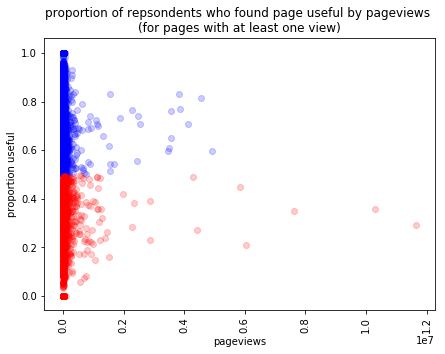

In [38]:
# normal values
plt.figure(figsize=(7, 5))
# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
plt.scatter(content_performance.pageviews[(content_performance['useful_per_responses']>=0.5) & (content_performance['pageviews']>1)],  
                                                       content_performance.useful_per_responses[(content_performance['useful_per_responses']>=0.5)  & (content_performance['pageviews']>1)], 
                                                                                                c = 'b',
                                                                                                alpha=0.2, 
                                                                                                )
# less than 0.8
plt.scatter(content_performance.pageviews[(content_performance['useful_per_responses']<0.5 ) & (content_performance['pageviews']>1)],  
                                                       content_performance.useful_per_responses[(content_performance['useful_per_responses']<0.5) & (content_performance['pageviews']>1)], 
                                                                                                c = 'red',
                                                                                                alpha=0.2, 
                                                                                                )




plt.title("proportion of repsondents who found page useful by pageviews \n(for pages with at least one view)")

plt.xticks(rotation=90)

# for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
#     if ((x>300 and y<0.8) or (x>1000)):
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')
#     if (y==1):
#         label = ""
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')

(array([-2000000.,        0.,  2000000.,  4000000.,  6000000.,  8000000.,
        10000000., 12000000., 14000000.]),
 <a list of 9 Text xticklabel objects>)

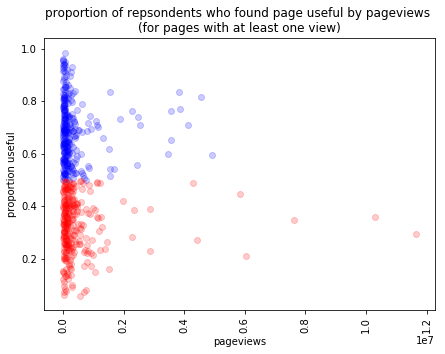

In [39]:
# normal values
plt.figure(figsize=(7, 5))
# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
plt.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']>=0.5) & (accurate_proportions['pageviews']>1)],  
                                                       accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']>=0.5)  & (accurate_proportions['pageviews']>1)], 
                                                                                                c = 'b',
                                                                                                alpha=0.2, 
                                                                                                )
# less than 0.8
plt.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']<0.5 ) & (accurate_proportions['pageviews']>1)],  
                                                       accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']<0.5) & (accurate_proportions['pageviews']>1)], 
                                                                                                c = 'red',
                                                                                                alpha=0.2, 
                                                                                                )




plt.title("proportion of repsondents who found page useful by pageviews \n(for pages with at least one view)")

plt.xticks(rotation=90)

# for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
#     if ((x>300 and y<0.8) or (x>1000)):
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')
#     if (y==1):
#         label = ""
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')

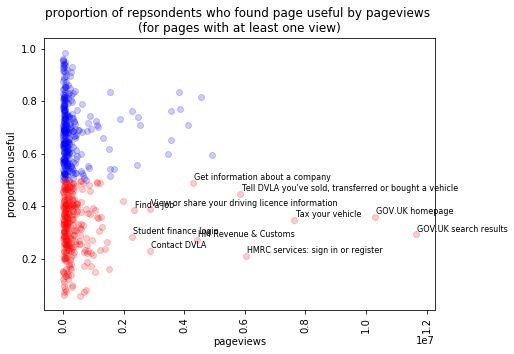

In [40]:
# normal values
fig, ax = plt.subplots(figsize=(7, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']>=0.5) & (accurate_proportions['pageviews']>1)],  
                                                       accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']>=0.5)  & (accurate_proportions['pageviews']>1)], 
                                                                                                c = 'b',
                                                                                                alpha=0.2, 
                                                                                                )
# less than 0.8
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']<0.5 ) & (accurate_proportions['pageviews']>1)],  
                                                       accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']<0.5) & (accurate_proportions['pageviews']>1)], 
                                                                                                c = 'red',
                                                                                                alpha=0.2, 
                                                                                                )




plt.title("proportion of repsondents who found page useful by pageviews \n(for pages with at least one view)")

plt.xticks(rotation=90)

# for i, txt in enumerate(accurate_proportions['base_path']):
    
#     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(accurate_proportions['title'], accurate_proportions['pageviews'], accurate_proportions['useful_per_responses']):
    if (x>2000000 and y<0.5):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=8,
            textcoords='offset points', ha='left', va='bottom')
#     if (y==1):
#         label = ""
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')

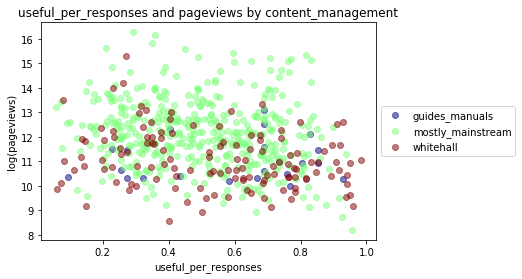

In [96]:
pf.scatter_byvar(df=accurate_proportions, x='useful_per_responses', y='pageviews', byvar='content_management', ylog=True, xlog=False)

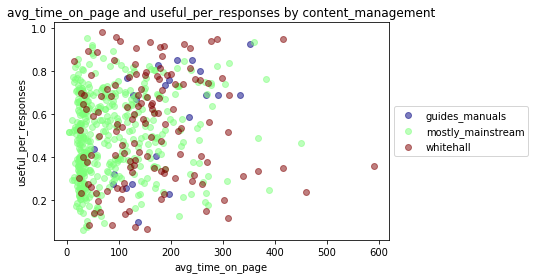

In [97]:
pf.scatter_byvar(df=accurate_proportions, x='avg_time_on_page', y='useful_per_responses', byvar='content_management', ylog=False, xlog=False)

/Users/ellieking/Documents/give-depts-data/python/plot_functions.py:86: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(group[x]), group[y], marker='o', linestyle='',  label=name, alpha=0.5)


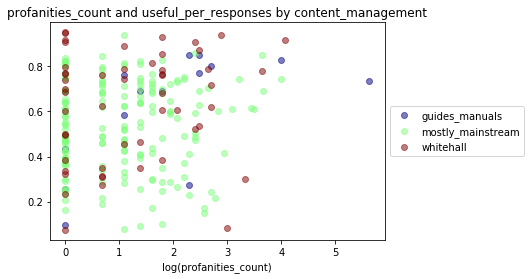

In [100]:
pf.scatter_byvar(df=accurate_proportions, x='profanities_count', y='useful_per_responses', byvar='content_management', ylog=False, xlog=True)

/Users/ellieking/Documents/give-depts-data/python/plot_functions.py:86: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(group[x]), group[y], marker='o', linestyle='',  label=name, alpha=0.5)


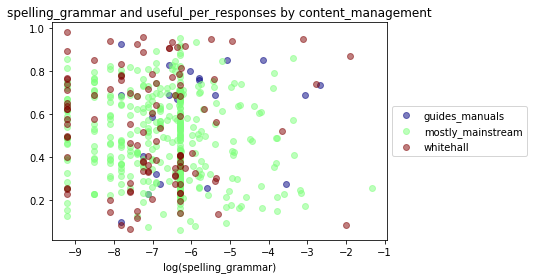

In [103]:
pf.scatter_byvar(df=accurate_proportions, x='spelling_grammar', y='useful_per_responses', byvar='content_management', ylog=False, xlog=True)

/Users/ellieking/Documents/give-depts-data/python/plot_functions.py:86: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(group[x]), group[y], marker='o', linestyle='',  label=name, alpha=0.5)


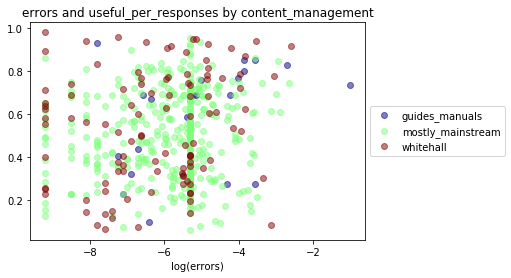

In [104]:
pf.scatter_byvar(df=accurate_proportions, x='errors', y='useful_per_responses', byvar='content_management', ylog=False, xlog=True)

### like CAB backlogger
https://wearecitizensadvice.org.uk/how-to-prioritise-3-000-pages-start-with-data-db107ac53e74


#### Need to improve

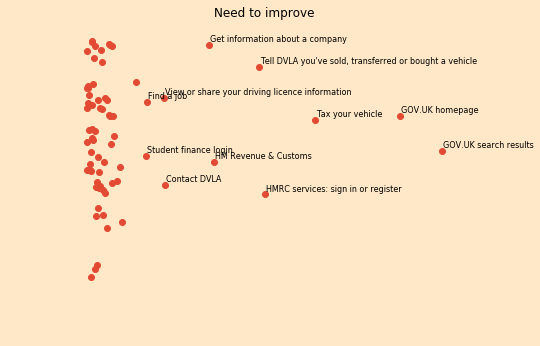

In [42]:
# normal values
fig, ax = plt.subplots(figsize=(7, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']<0.5) & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean())],  
        accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']<0.5)  & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean())], 
                                                                                                c = '#e34a33' 
                                                                                                )



fig.patch.set_facecolor('#fee8c8')
ax.set_facecolor('#fee8c8')
plt.title("Need to improve")
plt.axis('off')
plt.xticks(rotation=90)


# for i, txt in enumerate(accurate_proportions['base_path']):
    
#     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(accurate_proportions['title'], accurate_proportions['pageviews'], accurate_proportions['useful_per_responses']):
    if (x>2000000):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=8,
            textcoords='offset points', ha='left', va='bottom')


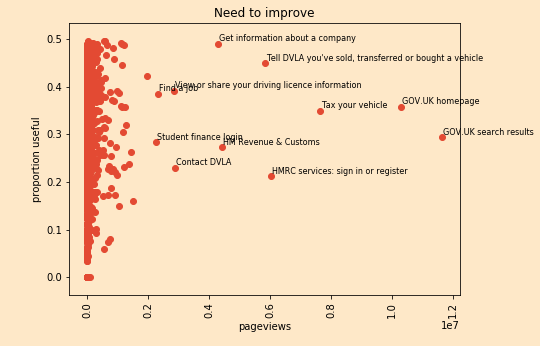

In [43]:
# normal values
fig, ax = plt.subplots(figsize=(7, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(content_performance.pageviews[(content_performance['useful_per_responses']<0.5) & (content_performance['pageviews']>content_performance['pageviews'].mean())],  
        content_performance.useful_per_responses[(content_performance['useful_per_responses']<0.5)  & (content_performance['pageviews']>content_performance['pageviews'].mean())], 
                                                                                                c = '#e34a33' 
                                                                                                )



fig.patch.set_facecolor('#fee8c8')
ax.set_facecolor('#fee8c8')
plt.title("Need to improve")

plt.xticks(rotation=90)


# for i, txt in enumerate(accurate_proportions['base_path']):
    
# #     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(content_performance['title'], content_performance['pageviews'], content_performance['useful_per_responses']):
    if (x>2000000):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=8,
            textcoords='offset points', ha='left', va='bottom')


(-14608.856571087217,
 422483.8565710872,
 0.028713077444964222,
 0.529199766591733)

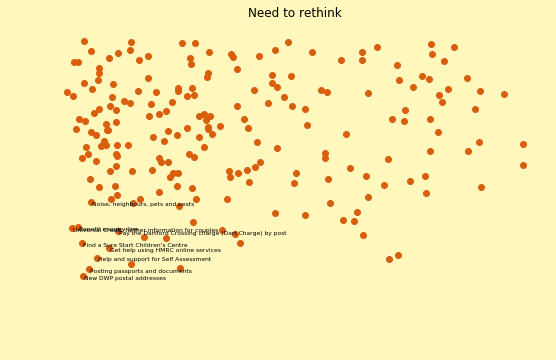

In [44]:
from adjustText import adjust_text

# normal values
fig, ax = plt.subplots(figsize=(9, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']<0.5) & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean())],  
        accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']<0.5)  & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean())], 
                                                                                                c = '#d95f0e' 
                                                                                                )



fig.patch.set_facecolor('#fff7bc')
ax.set_facecolor('#fff7bc')
plt.title("Need to rethink")

plt.xticks(rotation=90)

# for i, txt in enumerate(accurate_proportions['base_path']):
    
#     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(accurate_proportions['title'], accurate_proportions['pageviews'], accurate_proportions['useful_per_responses']):
    if (x<50000 and y<0.2):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=6, rotation=0,
            textcoords='offset points', ha='left', va='top')

plt.axis('off')


(197875.09155145925,
 5143978.908448542,
 0.47121483054098107,
 0.8616629515753799)

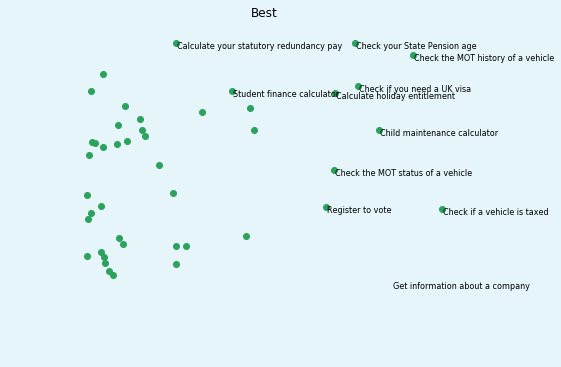

In [45]:
from adjustText import adjust_text

# normal values
fig, ax = plt.subplots(figsize=(7, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']>=0.5) & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean())],  
        accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']>=0.5)  & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean())], 
                                                                                                c = '#2ca25f' 
                                                                                                )



fig.patch.set_facecolor('#e5f5f9')
ax.set_facecolor('#e5f5f9')
plt.title("Best")

plt.xticks(rotation=90)

# for i, txt in enumerate(accurate_proportions['base_path']):
    
#     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(accurate_proportions['title'], accurate_proportions['pageviews'], accurate_proportions['useful_per_responses']):
    if (x>1000000 and y>0.75) or (x>3000000):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=8, rotation=0,
            textcoords='offset points', ha='left', va='top')

plt.axis('off')


(-16626.65844854071, 428865.6584485408, 0.4637596205477, 1.0182223614342822)

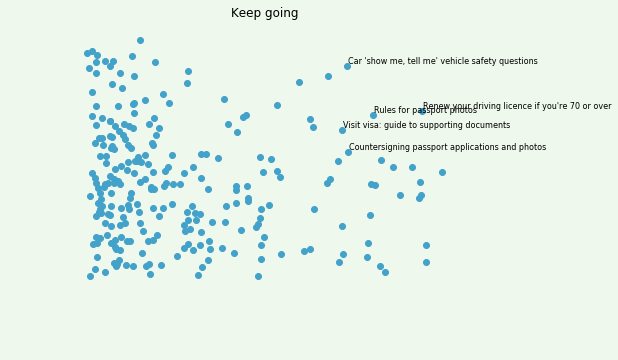

In [46]:
from adjustText import adjust_text

# normal values
fig, ax = plt.subplots(figsize=(7, 5))

# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
ax.scatter(accurate_proportions.pageviews[(accurate_proportions['useful_per_responses']>=0.5) & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean())],  
        accurate_proportions.useful_per_responses[(accurate_proportions['useful_per_responses']>=0.5)  & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean())], 
                                                                                                c = '#43a2ca' 
                                                                                                )



fig.patch.set_facecolor('#e0f3db')
fig.patch.set_alpha(0.5)
ax.set_facecolor('#e0f3db')
ax.patch.set_alpha(0.3)
plt.title("Keep going")

plt.xticks(rotation=90)

# for i, txt in enumerate(accurate_proportions['base_path']):
    
#     ax.annotate(txt, (accurate_proportions['pageviews'][i],accurate_proportions['useful_per_responses'][i]))

for label, x, y in zip(accurate_proportions['title'], accurate_proportions['pageviews'], accurate_proportions['useful_per_responses']):
    if (x>290000 and y>0.75):
        ax.annotate(
            label,
            xy=(x, y), xytext=(1, 1), size=8, rotation=0,
            textcoords='offset points', ha='left', va='bottom')


plt.axis('off')


In [47]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['doing_great', 'keep_going', 'need_to_rethink', 'need_to_improve'], ordered=True)
accurate_proportions['backlogger_status'] = [np.nan for i in range(len(accurate_proportions.index))]
accurate_proportions.loc[(accurate_proportions['useful_per_responses']>0.5) & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean()), 'backlogger_status'] = 'keep_going'
accurate_proportions.loc[(accurate_proportions['useful_per_responses']>0.5) & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean()), 'backlogger_status'] = 'doing_great'
accurate_proportions.loc[(accurate_proportions['useful_per_responses']<=0.5) & (accurate_proportions['pageviews']<=accurate_proportions['pageviews'].mean()), 'backlogger_status'] = 'need_to_rethink'
accurate_proportions.loc[(accurate_proportions['useful_per_responses']<=0.5) & (accurate_proportions['pageviews']>accurate_proportions['pageviews'].mean()), 'backlogger_status'] = 'need_to_improve'
accurate_proportions['backlogger_status'] = accurate_proportions['backlogger_status'].astype(cat_type)

In [48]:
colors=['#e5f5f9','#e0f3db',  '#fff7bc', '#fee8c8' ]
colors2=['#2ca25f','#43a2ca',  '#d95f0e', '#e34a33' ]

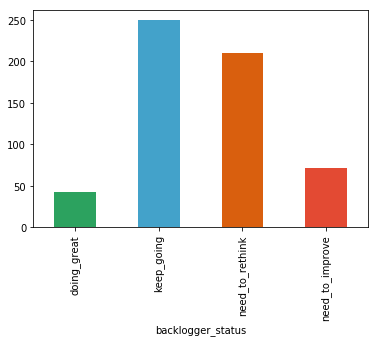

In [49]:
by_backlogger2 = accurate_proportions.groupby('backlogger_status')
counts = by_backlogger2.count()
sums = by_backlogger2.sum()
means = by_backlogger2.mean()
errors = 1.96*by_backlogger2.sem()
fig, ax = plt.subplots()

counts['spelling_grammar'].plot.bar( ax=ax, color=colors2)

In [50]:
print(by_backlogger2.groups)

{'doing_great': Int64Index([325794, 325897, 326931, 326932, 327030, 358740, 359979, 371703,
            380147, 381125, 387265, 387687, 387740, 388832, 392970, 392999,
            395740, 395838, 396463, 397091, 397184, 397197, 397234, 400897,
            405194, 406183, 410705, 410882, 412987, 417132, 417155, 417168,
            417170, 417174, 417176, 417180, 417187, 417188, 417191, 417245,
            417873, 420570, 420595],
           dtype='int64'), 'keep_going': Int64Index([ 74508,  74740, 145479, 147602, 148746, 156422, 157796, 157833,
            169870, 188744,
            ...
            418389, 418390, 418567, 420782, 423401, 423479, 426795, 426800,
            427479, 434461],
           dtype='int64', length=250), 'need_to_rethink': Int64Index([ 73693, 162727, 186012, 200677, 215591, 218995, 325008, 325449,
            325472, 325493,
            ...
            418572, 418605, 418690, 419415, 420559, 420560, 422020, 422891,
            422892, 426808],
           dtype='

In [51]:
next(iter(by_backlogger2.groups.values()))

Int64Index([325794, 325897, 326931, 326932, 327030, 358740, 359979, 371703,
            380147, 381125, 387265, 387687, 387740, 388832, 392970, 392999,
            395740, 395838, 396463, 397091, 397184, 397197, 397234, 400897,
            405194, 406183, 410705, 410882, 412987, 417132, 417155, 417168,
            417170, 417174, 417176, 417180, 417187, 417188, 417191, 417245,
            417873, 420570, 420595],
           dtype='int64')

In [52]:
by_backlogger2.get_group('keep_going').shape

(250, 65)

In [53]:
by_backlogger2.get_group('doing_great').shape

(43, 65)

In [54]:
len(next(iter(by_backlogger2.groups.values())))

43

The simplest method is based on approximating the Poisson distribution by a normal distribution. It should be used only when N is large (at least 50). You first calculate the SE of the event rate. The Poisson distribution tells us that the SE of the total observed number of counts (N) is simply the square root of N, so the SE of the event rate is given by:

SE=sqrt(N)/T
Using these numbers, N = 36 and T=3, the SE for the event rate is

image1.png
Then you use the normal-based formulas, which say that the CI around the observed rate is equal to the observed rate ± k×SE.

k is 1.96 for 95 percent CLs. So CLL = 12.0 – 1.96 x 1.67 and CLU = 12.0 + 1.96 x 1.67, which works out to 95 percent confidence limits of 8.73 and 15.27. You report your result this way: “The fatal accident rate was 12.0, 95%CI = 8.7–15.3 fatal accidents per month.”

If you wanted to calculate the CI around the total 3-month accident count itself (rather than around the monthly rate), you would estimate the SE of the count N as

SE=sqrt(N)
So the SE of the 36 observed fatal accidents in a three-month period is simply

sqrt(36)=6
which equals 6.0. Then you would calculate the CI around the observed count, using the normal-based formulas. So CLL = 36.0 – 1.96 x 6.0 and CLH = 36.0 + 1.96 x 6.0, which works out to a 95 percent CI of 24.2 to 47.8 accidents in a three-month period.

In [55]:
poisson_errors = np.sqrt(by_backlogger2.sum())*1.96

/Users/ellieking/Documents/give-depts-data/give_data/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [56]:
poisson_errors

,Unnamed: 0,pageviews,unique_pageviews,feedex_comments,is_this_useful_yes,is_this_useful_no,number_of_internal_searches,exits,entrances,bounce_rate,...,repeated_words_count_scaled,spell_count_scaled,readability_score_scaled,equality_count_scaled,passive_count_scaled,simplify_count_scaled,profanities_count_scaled,spelling_grammar,style,errors
backlogger_status,,,,,,,,,,,,,,,,,,,,,
doing_great,6391.645949,16315.513157,12133.564862,647.485637,530.472470,344.095849,660.723529,7837.406246,7745.403945,84.454756,...,0.487395,0.407461,1.349701,0.368630,0.682749,0.730959,0.913300,0.656884,1.719892,1.000071
keep_going,15986.010525,10375.450083,8710.136575,432.396612,474.793565,320.272636,596.935046,5983.441825,6033.625620,204.496500,...,0.708043,1.197286,3.453364,0.980558,2.151492,2.286768,2.421287,1.763862,4.769218,2.701134
need_to_rethink,15361.896215,10835.629866,9264.000284,71.854787,269.533852,384.104996,964.923348,5310.430019,5659.331234,158.054079,...,0.533803,1.108401,3.079577,0.980792,2.010687,1.770315,1.452654,1.422587,4.197931,1.827227
need_to_improve,8902.035619,20575.007181,17429.332263,102.801953,345.527488,521.581006,3534.809329,9757.913493,9551.756504,89.343951,...,1.183266,0.771174,1.916039,0.535584,1.192539,1.034259,0.905372,1.612230,2.539665,1.189289


In [57]:
sums['spell_count']

backlogger_status
doing_great         346.0
keep_going         3232.0
need_to_rethink    2534.0
need_to_improve    1336.0
Name: spell_count, dtype: float64

In [58]:
np.sqrt(sums['spell_count'])*1.96

backlogger_status
doing_great         36.458107
keep_going         111.427336
need_to_rethink     98.664150
need_to_improve     71.640614
Name: spell_count, dtype: float64

In [59]:
sums['spell_count'] + np.sqrt(sums['spell_count'])*1.96

backlogger_status
doing_great         382.458107
keep_going         3343.427336
need_to_rethink    2632.664150
need_to_improve    1407.640614
Name: spell_count, dtype: float64

In [60]:
sums['spell_count'] - np.sqrt(sums['spell_count'])*1.96

backlogger_status
doing_great         309.541893
keep_going         3120.572664
need_to_rethink    2435.335850
need_to_improve    1264.359386
Name: spell_count, dtype: float64

In [61]:
means['spell_count']

backlogger_status
doing_great         9.611111
keep_going         15.390476
need_to_rethink    16.243590
need_to_improve    24.290909
Name: spell_count, dtype: float64

In [62]:
means['pageviews'] + 379.4

backlogger_status
doing_great        1.611844e+06
keep_going         1.124681e+05
need_to_rethink    1.459176e+05
need_to_improve    1.530887e+06
Name: pageviews, dtype: float64

In [63]:
means['spelling_grammar']

backlogger_status
doing_great        0.002612
keep_going         0.003239
need_to_rethink    0.002509
need_to_improve    0.009397
Name: spelling_grammar, dtype: float64

In [64]:
errors['spelling_grammar']

backlogger_status
doing_great        0.002311
keep_going         0.001487
need_to_rethink    0.000734
need_to_improve    0.008080
Name: spelling_grammar, dtype: float64

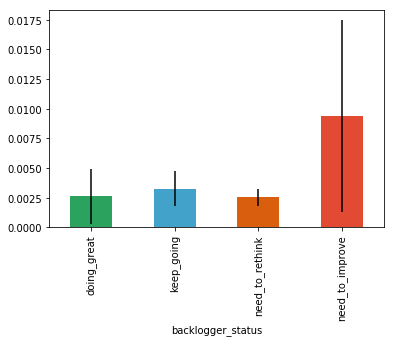

In [65]:
fig, ax = plt.subplots()
means['spelling_grammar'].plot.bar(yerr=errors['spelling_grammar'], ax=ax, color=colors2)

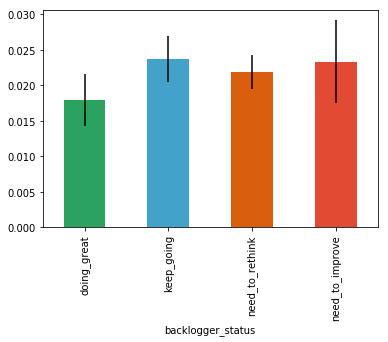

In [66]:
fig, ax = plt.subplots()
means['style'].plot.bar(yerr=errors['style'], ax=ax, color=colors2)

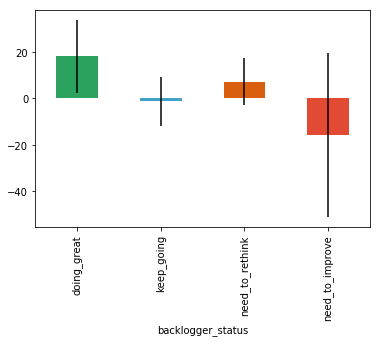

In [67]:
fig, ax = plt.subplots()
means['readability_score'].plot.bar(yerr=errors['readability_score'], ax=ax, color=colors2)

Text(0.5,1,'Total number of spelling errors over period, with 95% CI based on poisson distribution')

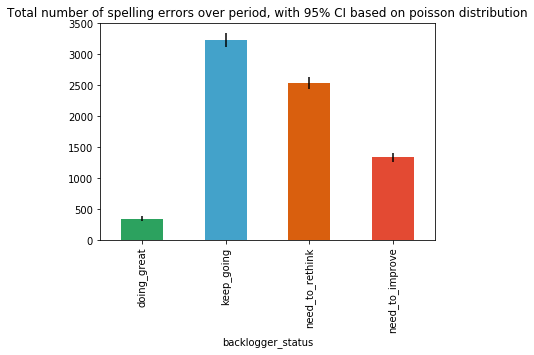

In [68]:
fig, ax = plt.subplots()
sums['spell_count'].plot.bar(yerr=poisson_errors['spell_count'], ax=ax, color=colors2)
plt.title("Total number of spelling errors over period, with 95% CI based on poisson distribution")

Text(0.5,1,'Number of spelling errors per day, with 95% CI based on normal distribution')

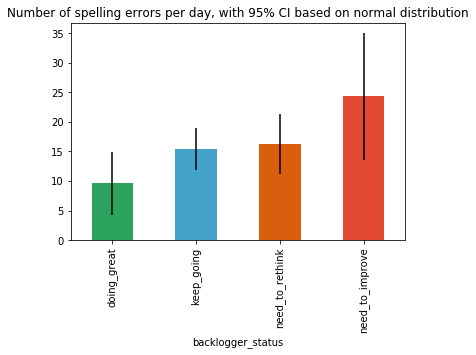

In [69]:
fig, ax = plt.subplots()
means['spell_count'].plot.bar(yerr=errors['spell_count'], ax=ax, color=colors2)
plt.title("Number of spelling errors per day, with 95% CI based on normal distribution")

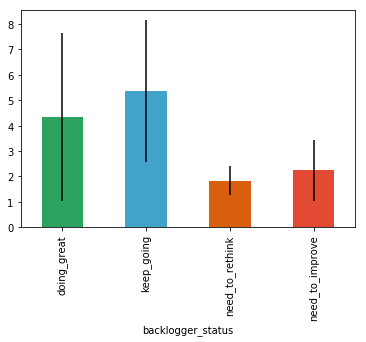

In [70]:
fig, ax = plt.subplots()
means['profanities_count'].plot.bar(yerr=errors['profanities_count'], ax=ax, color=colors2)

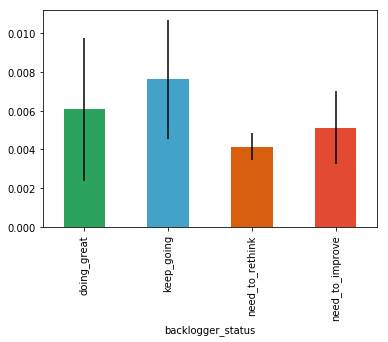

In [71]:
fig, ax = plt.subplots()
means['errors'].plot.bar(yerr=errors['errors'], ax=ax, color=colors2)

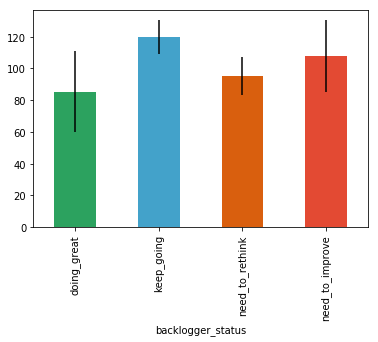

In [72]:
fig, ax = plt.subplots()
means['avg_time_on_page'].plot.bar(yerr=errors['avg_time_on_page'], ax=ax, color=colors2)

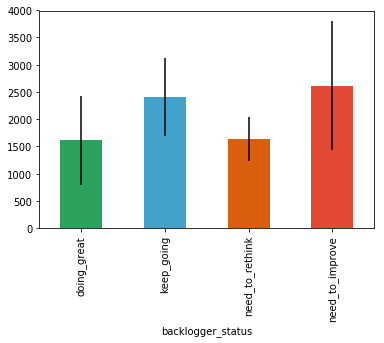

In [73]:
fig, ax = plt.subplots()
means['string_length'].plot.bar(yerr=errors['string_length'], ax=ax, color=colors2)

In [74]:
means.columns

Index(['Unnamed: 0', 'pageviews', 'unique_pageviews', 'feedex_comments',
       'is_this_useful_yes', 'is_this_useful_no',
       'number_of_internal_searches', 'exits', 'entrances', 'bounce_rate',
       'avg_time_on_page', 'id', 'number_of_pdfs', 'number_of_word_files',
       'readability_score', 'contractions_count', 'equality_count',
       'indefinite_article_count', 'passive_count', 'profanities_count',
       'redundant_acronyms_count', 'repeated_words_count', 'simplify_count',
       'spell_count', 'string_length', 'sentence_count', 'word_count',
       'publishing_api_payload_version', 'count_survey_responses',
       'response_per_pageview', 'response_per_unique_pageview',
       'useful_per_responses', 'total_to_unique_pageviews',
       'create_total_to_unique_pageviews', 'feedex_per_unique_1000',
       'searches_per_pageview_1000', 'contractions_count_scaled',
       'indefinite_article_count_scaled', 'redundant_acronyms_count_scaled',
       'repeated_words_count_scaled

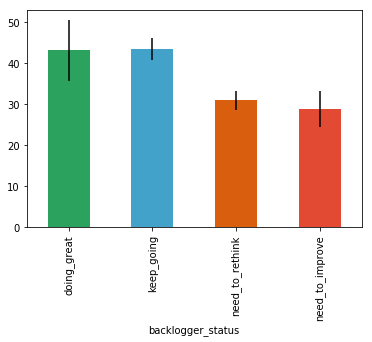

In [75]:
fig, ax = plt.subplots()
means['bounce_rate'].plot.bar(yerr=errors['bounce_rate'], ax=ax, color=colors2)

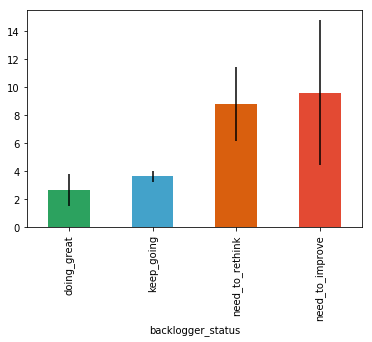

In [76]:
fig, ax = plt.subplots()
means['searches_per_pageview_1000'].plot.bar(yerr=errors['searches_per_pageview_1000'], ax=ax, color=colors2)

In [77]:
means

,Unnamed: 0,pageviews,unique_pageviews,feedex_comments,is_this_useful_yes,is_this_useful_no,number_of_internal_searches,exits,entrances,bounce_rate,...,repeated_words_count_scaled,spell_count_scaled,readability_score_scaled,equality_count_scaled,passive_count_scaled,simplify_count_scaled,profanities_count_scaled,spelling_grammar,style,errors
backlogger_status,,,,,,,,,,,,,,,,,,,,,
doing_great,247311.790698,1.611465e+06,8.912432e+05,2537.930233,1703.511628,716.767442,2642.767442,371846.860465,363167.976744,43.178507,...,0.001438,0.001005,0.011028,0.000823,0.002822,0.003234,0.005049,0.002612,0.017907,0.006055
keep_going,266089.684000,1.120887e+05,7.899467e+04,194.676000,234.724000,106.804000,371.024000,37277.776000,37905.704000,43.543126,...,0.000522,0.001493,0.012417,0.001001,0.004820,0.005445,0.006104,0.003239,0.023683,0.007597
need_to_rethink,292521.785714,1.455382e+05,1.063814e+05,6.400000,90.052381,182.880952,1154.128571,34956.500000,39700.757143,30.965634,...,0.000353,0.001523,0.011756,0.001192,0.005011,0.003885,0.002616,0.002509,0.021844,0.004139
need_to_improve,286506.194444,1.530507e+06,1.098290e+06,38.208333,431.638889,983.555556,45173.875000,344246.305556,329854.069444,28.859292,...,0.005062,0.002150,0.013273,0.001037,0.005142,0.003867,0.002964,0.009397,0.023319,0.005114


In [78]:
errors

,Unnamed: 0,_merge,avg_time_on_page,base_path,bounce_rate,content_hash,content_id,content_management,content_purpose_document_supertype,contractions_count,...,spell_count_scaled,spelling_grammar,status,string_length,style,title,total_to_unique_pageviews,unique_pageviews,useful_per_responses,word_count
backlogger_status,,,,,,,,,,,,,,,,,,,,,
doing_great,29549.912133,NaN,25.469677,NaN,7.404732,NaN,NaN,NaN,NaN,0.054444,...,0.000451,0.002311,NaN,819.811442,0.003667,NaN,1.040554,295519.611519,0.028857,150.718687
keep_going,13171.861812,NaN,10.535941,NaN,2.692877,NaN,NaN,NaN,NaN,0.024541,...,0.000306,0.001487,NaN,709.212498,0.003247,NaN,0.144288,9364.987141,0.014495,118.181244
need_to_rethink,14041.438900,NaN,11.992379,NaN,2.312422,NaN,NaN,NaN,NaN,0.064176,...,0.000376,0.000734,NaN,405.421606,0.002396,NaN,0.115206,11165.546065,0.014524,74.608973
need_to_improve,18819.677666,NaN,22.770341,NaN,4.348199,NaN,NaN,NaN,NaN,0.935764,...,0.000829,0.008080,NaN,1183.213581,0.005864,NaN,0.178553,371998.805504,0.025443,222.572316


In [79]:
by_backlogger = accurate_proportions.groupby('backlogger_status').agg(['mean', 'sem'])

In [80]:
by_backlogger

Unnamed: 0                   pageviews                 \
                            mean           sem          mean            sem   
backlogger_status                                                             
doing_great        247311.790698  15076.485782  1.611465e+06  198414.514550   
keep_going         266089.684000   6720.337659  1.120887e+05    6462.725170   
need_to_rethink    292521.785714   7163.999439  1.455382e+05    7296.863459   
need_to_improve    286506.194444   9601.876360  1.530507e+06  247778.916624   

                  unique_pageviews                feedex_comments  \
                              mean            sem            mean   
backlogger_status                                                   
doing_great           8.912432e+05  150775.312000     2537.930233   
keep_going            7.899467e+04    4778.054664      194.676000   
need_to_rethink       1.063814e+05    5696.707176        6.400000   
need_to_improve       1.098290e+06  189795.308931       38.208333   

                               is_this_useful_yes                ...     \
                           sem               mean         sem    ...      
backlogger_status                                                ...      
doing_great        2511.535706        1703.511628  423.528424    ...      
keep_going           61.390121         234.724000   17.539700    ...      
need_to_rethink       0.735526          90.052381    6.627553    ...      
need_to_improve       8.911228         431.638889   83.015974    ...      

                  simplify_count_scaled           profanities_count_scaled  \
                                   mean       sem                     mean   
backlogger_status                                                            
doing_great                    0.003234  0.000848                 0.005049   
keep_going                     0.005445  0.000925                 0.006104   
need_to_rethink                0.003885  0.000454                 0.002616   
need_to_improve                0.003867  0.000638                 0.002964   

                            spelling_grammar               style            \
                        sem             mean       sem      mean       sem   
backlogger_status                                                            
doing_great        0.001729         0.002612  0.001179  0.017907  0.001871   
keep_going         0.001472         0.003239  0.000759  0.023683  0.001657   
need_to_rethink    0.000266         0.002509  0.000374  0.021844  0.001222   
need_to_improve    0.000574         0.009397  0.004122  0.023319  0.002992   

                     errors            
                       mean       sem  
backlogger_status                      
doing_great        0.006055  0.001882  
keep_going         0.007597  0.001560  
need_to_rethink    0.004139  0.000350  
need_to_improve    0.005114  0.000957  

[4 rows x 98 columns]

(0, 100)

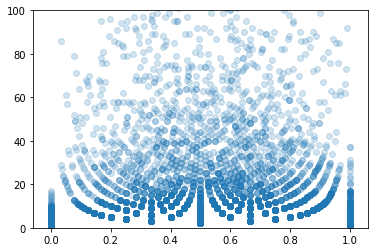

In [87]:
plt.scatter(content_performance.useful_per_responses, content_performance.count_survey_responses, alpha=0.2)
plt.ylim(0, 100)

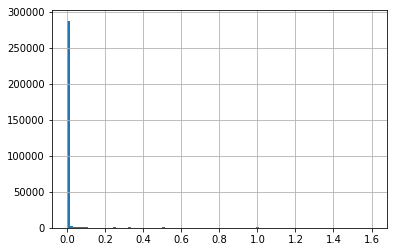

In [88]:
content_performance.response_per_pageview.hist(bins=100)

#### responses_unique_per_pageview

In [89]:
content_performance.response_per_unique_pageview.describe()

count    299340.000000
mean          0.008037
std           0.064241
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: response_per_unique_pageview, dtype: float64

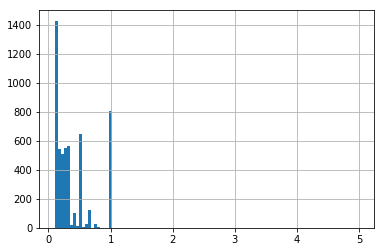

In [90]:
content_performance.response_per_unique_pageview.hist(bins=100, range=(0.1, 5))